In [24]:
!export PATH=/Library/TeX/texbin:$PATH

In [ ]:
import os
import re
import unicodedata
import warnings
warnings.filterwarnings('ignore')
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import pickle
import string
import unicodedata
from random import randint
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed

# Download data

In [ ]:
import title_generator
from data.pubmed_keywords import KEYWORDS

title_generator.fetch_abstracts_and_title(KEYWORDS, 1000, "abstracts_and_titles_1000x100")

# Load data

In [16]:
data = pd.read_csv("./data/abstracts_and_titles_1000x100.csv", header = None, names = ["Abstract", "Title"])
data.head()

,Abstract,Title
0,"Despite being rarely discussed, perinephric ly...","Perirenal lymphatics: anatomy, pathophysiology..."
1,Hydrazoic acid (HN<sub>3</sub>) and its deprot...,How Azide Ion/Hydrazoic Acid Passes Through Bi...
2,The historical use of the marijuana plant for ...,Disposition of a single oral dose of a cannabi...
3,Supraspinatus muscle atrophy is commonly assoc...,Supraspinatus muscle atrophy in relation to ag...
4,"Ornithine α-ketoglutarate (OKG), a nutritional...",Effect of Ornithine α-Ketoglutarate on Intesti...


# Translate data into Polish

In [ ]:
translated_data = [(title_generator.translate_to_polish(x[0]), title_generator.translate_to_polish(x[1])) for x in tqdm(data)]

with open(
    os.path.join("./data/translated_data_to_pl.csv"), "w", newline=""
) as f:
    writer = csv.writer(f)
    writer.writerows(translated_data)

In [17]:
rows = [tuple(row) for row in csv.reader(open("./data/translated_data_to_pl.csv", 'r'))]

data = pd.DataFrame(rows, columns=["Abstract", "Title"])
data.head()

,Abstract,Title
0,"Pomimo rzadkiej dyskusji, naczynia chłonne oko...","Układ chłonny okołonerkowy: anatomia, patofizj..."
1,Kwas azotowodorowy (HN<sub>3</sub>) i jego zde...,Jak jon azydkowy / kwas hydrazowy przechodzi p...
2,Historyczne zastosowanie rośliny marihuany do ...,Dyspozycja pojedynczej dawki doustnej leku kan...
3,Zanik mięśnia nadgrzebieniowego jest powszechn...,Zanik mięśni nadgrzebieniowych w związku ze st...
4,"α-ketoglutaran ornityny (OKG), związek odżywcz...",Wpływ α-ketoglutaranu ornityny na mikroflorę j...


# Preprocessing

1) Lower case transform
2) Remove html tags
3) remove https links
4) remove text inside all types of brackets
5) remove digits
6) polish tokenizer
7) remove stopwords

In [5]:
data_pre_proc = title_generator.pre_processing(data)

data_pre_proc

[PREPROCESSING]  'lower_case_preprocessing'
[PREPROCESSING] Done!
[PREPROCESSING]  'html_tags_preprocessing'
[PREPROCESSING] Done!
[PREPROCESSING]  'https_pre_processing'
[PREPROCESSING] Done!
[PREPROCESSING]  'brackets_preprocessing'
[PREPROCESSING] Done!
[PREPROCESSING]  'digits_preprocessing'
[PREPROCESSING] Done!
[PREPROCESSING]  'polish_words_tokenize'


Tokenizing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [12:17<00:00, 81.32element/s]


[PREPROCESSING] Done!
[PREPROCESSING]  'punctuation_preprocessing'
[PREPROCESSING] Done!
[PREPROCESSING]  'polish_stopwords_preprocessing'
[PREPROCESSING] Done!


,Abstract,Title
0,"[zaburzenie, limfoproliferacyjne, reprezentuje...","[zaburzenie, limfoproliferacyjne, leczenia, te..."
1,"[nośniki, substancji, rozpuszczonych, niezbędn...","[wpływ, transporterów, nośników, rozpuszczonyc..."
2,"[zanieczyszczenia, środowiska, stanowią, zagro...","[potencjalnie, toksyczne, metale, kurzu, krwi,..."
3,"[genisteina, powszechnie, występujący, izoflaw...","[genisteina, obiecujący, modulator, apoptozy, ..."
4,"[c, brachyspora, szeroko, rozpowszechniony, gr...","[biotechnologiczne, zastosowanie, egzopolisach..."
...,...,...
29995,"[wyniku, wysiłku, fizycznego, mięśnie, uwalnia...","[krótkoterminowe, leczenie, iryzyną, zwiększył..."
29996,"[nowotwory, główną, przyczyną, zachorowalności...","[odkrycie, hipotez, nowych, predyktorów, raka,..."
29997,"[brakuje, skutecznych, terapii, farmakologiczn...","[randomizowane, badanie, pilotażowe, metod, mi..."
29998,"[astrocyty, pełnią, podstawowych, funkcji, móz...","[zanikowe, astrocyty, starych, marmozet, wykaz..."


In [4]:
type(data["Abstract"][0])

list

# Word Cloud

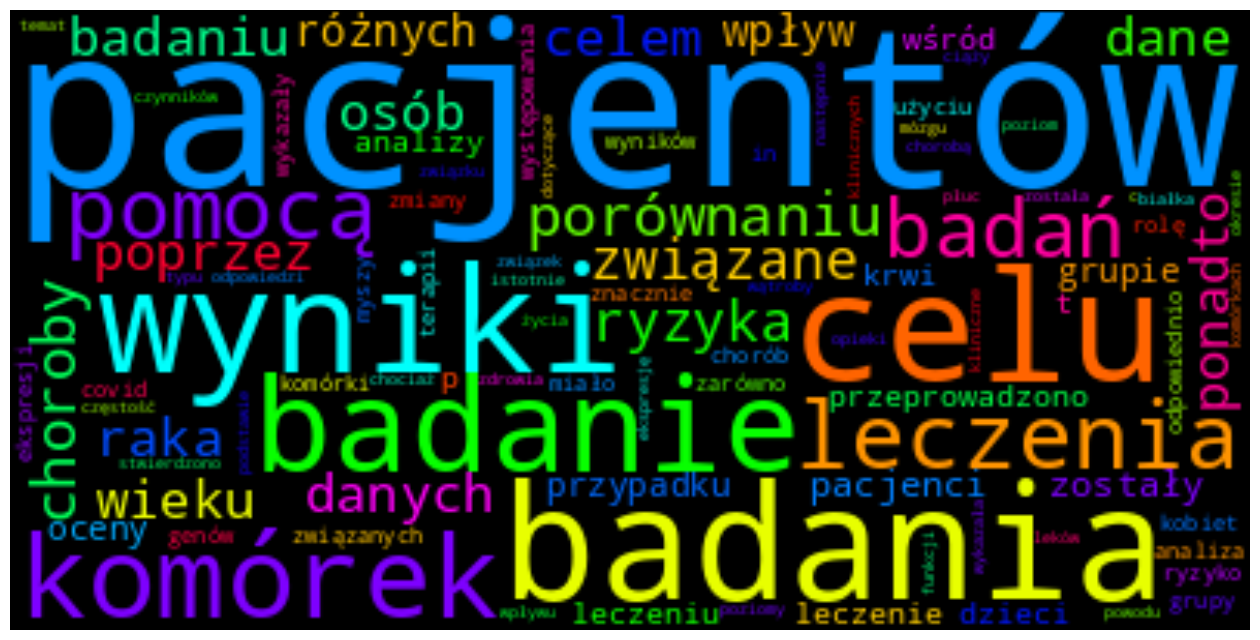

In [48]:
from wordcloud import WordCloud 
from nltk.probability import FreqDist

fd_abstracts = FreqDist([item for sublist in data["Abstract"] for item in sublist])

cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(fd_abstracts)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

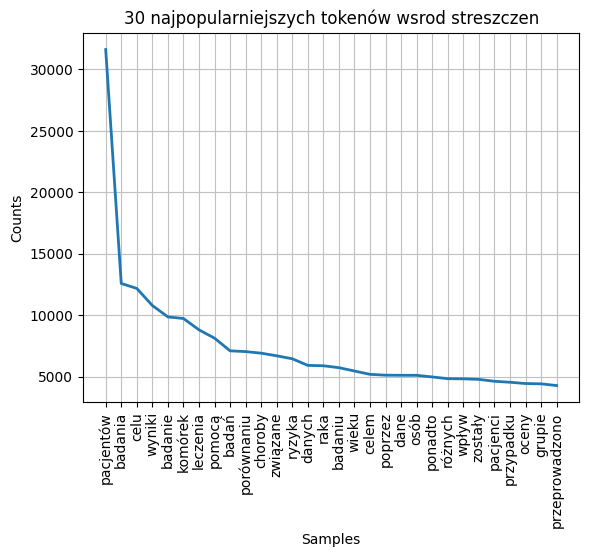

In [49]:
fd_abstracts.plot(30,title='30 najpopularniejszych tokenów wsrod streszczen')
plt.show()

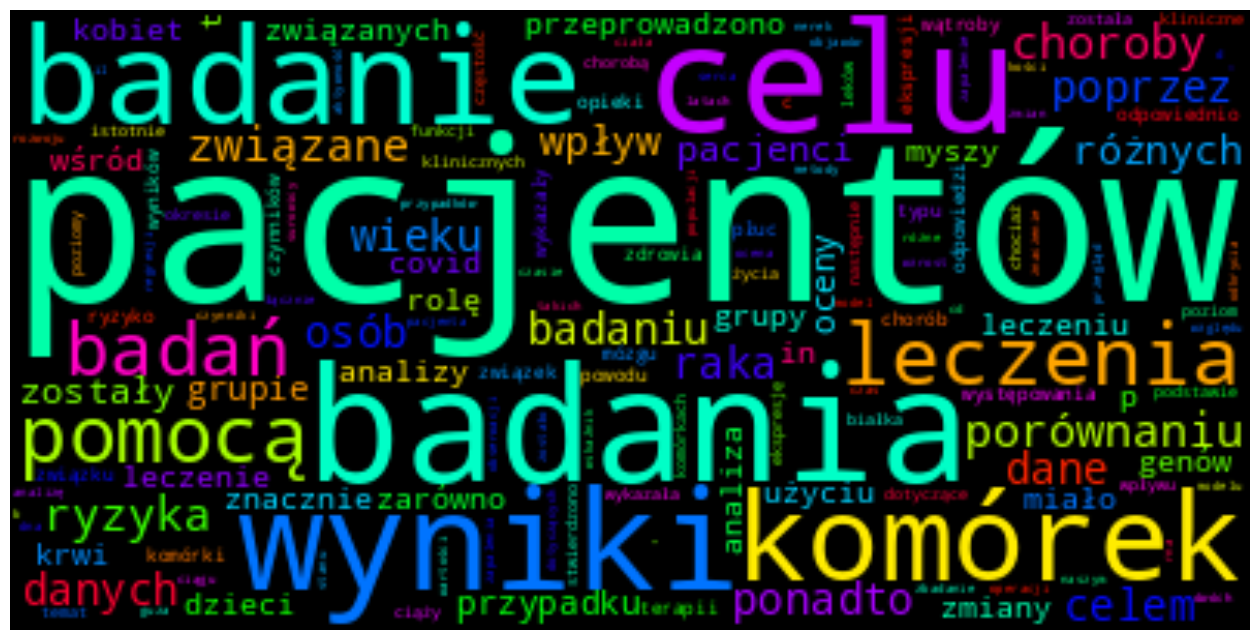

In [50]:
fd_titles = FreqDist([item for sublist in data["Title"] for item in sublist])

cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(fd_abstracts)
plt.figure(figsize=(16,12)) #wymiar obrazka
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

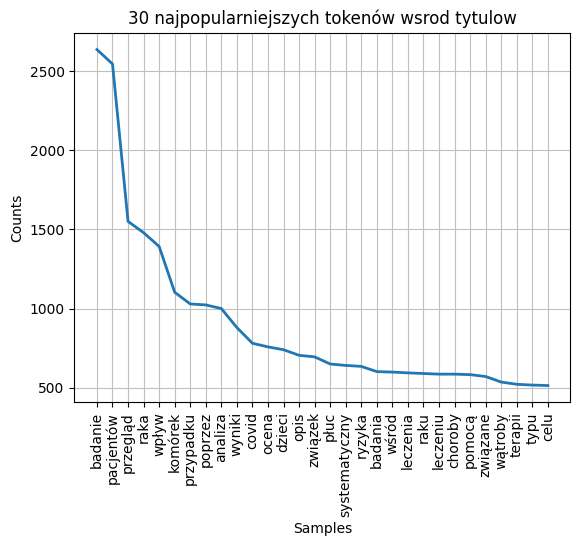

In [51]:
fd_titles.plot(30,title='30 najpopularniejszych tokenów wsrod tytulow')
plt.show()

# Trim data

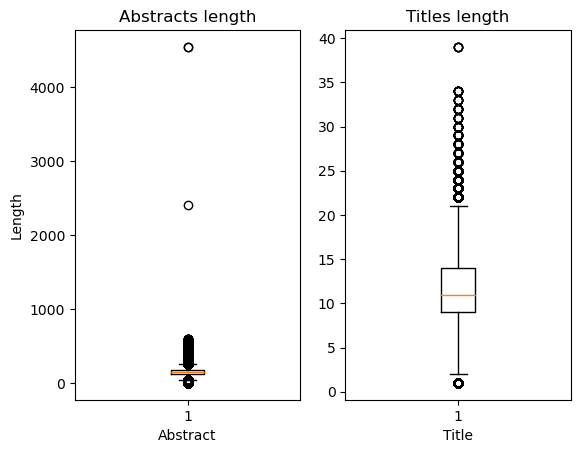

In [5]:
abstract_len = data["Abstract"].apply(lambda x: len(x))
title_len = data["Title"].apply(lambda x: len(x))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.boxplot(abstract_len)
ax2.boxplot(title_len)

ax1.set_xlabel('Abstract')
ax1.set_ylabel('Length')
ax1.set_title('Abstracts length')
ax2.set_xlabel('Title')
ax2.set_title('Titles length')

plt.show()

In [6]:
MAX_ABSTRACT_LEN = int(abstract_len.quantile([.90]).iloc[0])
MAX_ABSTRACT_LEN

205

90 % danych ma abstrakty dlugosci 205 slow lub mniej. Sensowne wydaje sie ogranicznie dlugosci abstraktow do tej liczby **205**

In [7]:
MAX_TITLE_LEN = int(title_len.quantile([.90]).iloc[0])
MAX_TITLE_LEN

17

90 % danych ma tytlu dlugosci 17 slow lub mniej. Sensowne wydaje sie ogranicznie dlugosci tytulow do tej liczby **17**

In [8]:
trim_data_abstracts = data["Abstract"].apply(lambda x: x[: MAX_ABSTRACT_LEN])
trim_data_titles = data["Title"].apply(lambda x: x[: MAX_TITLE_LEN])
data["Abstract"] = trim_data_abstracts
data["Title"] = trim_data_titles
data.head()

,Abstract,Title
0,"['badania', 'wykazały', 'kobiety', 'jadłowstrę...","['ciało', 'twarze', 'podwójne', 'standardy', '..."
1,"['brak', 'bezpieczeństwa', 'żywnościowego', 'd...","['niepewność', 'żywieniowa', 'zaburzenia', 'na..."
2,"['artykuł', 'opisuje', 'analizuje', 'różne', '...","['neurobiologia', 'zdezorganizowanego', 'przyw..."
3,"['jadłowstręt', 'psychiczny', 'poważnym', 'pot...","['retrospektywne', 'badanie', 'leczenia', 'far..."
4,"['chociaż', 'programy', 'zapobiegania', 'cyber...","['długoterminowa', 'skuteczność', 'trwałość', ..."


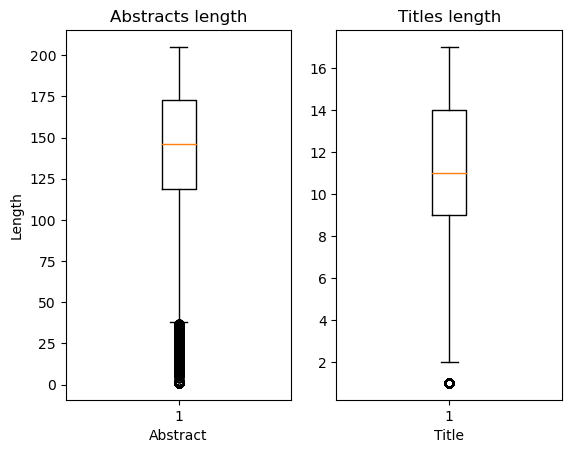

In [9]:
# After trim
abstract_len = data["Abstract"].apply(lambda x: len(x))
title_len = data["Title"].apply(lambda x: len(x))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.boxplot(abstract_len)
ax2.boxplot(title_len)

ax1.set_xlabel('Abstract')
ax1.set_ylabel('Length')
ax1.set_title('Abstracts length')
ax2.set_xlabel('Title')
ax2.set_title('Titles length')

plt.show()

# Add BOS and EOS

In [11]:
data['Title'] = data['Title'].apply(lambda x: ["<start>"] + x)
data['Title'] = data['Title'].apply(lambda x: x + ["<end>"])
data.head()

,Abstract,Title
0,"['badania', 'wykazały', 'kobiety', 'jadłowstrę...","[<start>, 'ciało', 'twarze', 'podwójne', 'stan..."
1,"['brak', 'bezpieczeństwa', 'żywnościowego', 'd...","[<start>, 'niepewność', 'żywieniowa', 'zaburze..."
2,"['artykuł', 'opisuje', 'analizuje', 'różne', '...","[<start>, 'neurobiologia', 'zdezorganizowanego..."
3,"['jadłowstręt', 'psychiczny', 'poważnym', 'pot...","[<start>, 'retrospektywne', 'badanie', 'leczen..."
4,"['chociaż', 'programy', 'zapobiegania', 'cyber...","[<start>, 'długoterminowa', 'skuteczność', 'tr..."


In [12]:
data["Title"][0][0]

'<start>'

In [13]:
data["Title"][0][-1]

'<end>'

# Vocab

In [14]:
def build_vocabulary(series):
    vocabulary = {}
    index = 1  # Start index from 1 (assuming 0 is reserved for padding or unknown words)
    for tokens in series:
        for token in tokens:
            if token not in vocabulary:
                vocabulary[token] = index
                index += 1
    return vocabulary

abstract_vocab = build_vocabulary(data["Abstract"])
title_vocab = build_vocabulary(data["Title"])
print(len(abstract_vocab))
print(len(title_vocab))

211205
67193


# Word to ix

In [15]:
def word_to_ix(tokens, vocab):
    word_to_ix = []
    for token in tokens:
        word_to_ix.append(vocab[token])
    return word_to_ix

In [16]:
data["Abstract"] = data["Abstract"].apply(lambda x: word_to_ix(x, abstract_vocab))
data["Title"] = data["Title"].apply(lambda x: word_to_ix(x, title_vocab))

data.head()

,Abstract,Title
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,"[126, 127, 128, 129, 126, 130, 131, 132, 133, ...","[1, 20, 21, 22, 11, 12, 23, 24, 25, 19]"
2,"[224, 225, 226, 227, 228, 229, 230, 231, 232, ...","[1, 26, 27, 28, 29, 30, 31, 32, 33, 19]"
3,"[297, 298, 299, 300, 301, 302, 20, 82, 303, 30...","[1, 34, 35, 36, 37, 38, 39, 40, 40, 41, 19]"
4,"[423, 424, 425, 426, 427, 428, 429, 430, 431, ...","[1, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52..."


# Split data on test, train

In [17]:
X_train, X_test = train_test_split(data, test_size=0.1)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

print(X_train.shape)
print(X_test.shape)

(75920, 2)
(8436, 2)


In [18]:
X_train.head()

,Abstract,Title
0,"[6353, 3506, 52862, 2706, 706, 8058, 1582, 121...","[1, 12089, 14040, 7753, 6763, 8153, 561, 277, ..."
1,"[4055, 7093, 5791, 27984, 3137, 1881, 12940, 8...","[1, 420, 5667, 3130, 5902, 696, 238, 1011, 786..."
2,"[21801, 3129, 441, 100, 696, 1687, 4503, 42761...","[1, 500, 793, 13451, 30843, 812, 3635, 19]"
3,"[2796, 7648, 547, 23399, 8951, 6287, 379, 1013...","[1, 4100, 4101, 35, 7577, 1332, 2775, 86, 1130..."
4,"[565, 32315, 7370, 5053, 13171, 3083, 3034, 29...","[1, 12892, 1006, 553, 12893, 1482, 12894, 2131..."


# Pad data

In [19]:
abstract_train = pad_sequences(X_train["Abstract"], maxlen=MAX_ABSTRACT_LEN, padding='post', truncating='post')
abstract_test = pad_sequences(X_test["Abstract"], maxlen=MAX_ABSTRACT_LEN, padding='post', truncating='post')

title_train = pad_sequences(X_train["Title"], maxlen=MAX_TITLE_LEN, padding='post', truncating='post')
title_test = pad_sequences(X_test["Title"], maxlen=MAX_TITLE_LEN, padding='post', truncating='post')

In [20]:
type(title_train)

numpy.ndarray

In [21]:
abstract_vocab_size = len(abstract_vocab) + 1
title_vocab_size = len(title_vocab) + 1

print(f'Title vocab size: {title_vocab_size}')
print(f'Abstract vocab size: {abstract_vocab_size}')

Title vocab size: 67194
Abstract vocab size: 211206


# Pretrained Embedding Matrix

In [22]:
EMBEDDING_DIM = 100

In [23]:
%%time
embeddings_index = dict()
with open(f'../input/polish-w2v/cbow_v100m8.w2v.txt') as f:
    for n, line in enumerate(f):
        if n == 0:
            continue # skip first line
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1: ], dtype='float32')
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index)} word vectors.')

Found 2283384 word vectors.
CPU times: user 1min 17s, sys: 2.78 s, total: 1min 20s
Wall time: 1min 24s


In [24]:
title_embedding_matrix = np.zeros((title_vocab_size, EMBEDDING_DIM))
for word, i in title_vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        title_embedding_matrix[i] = embedding_vector

abstract_embedding_matrix = np.zeros((abstract_vocab_size, EMBEDDING_DIM))
for word, i in abstract_vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        abstract_embedding_matrix[i] = embedding_vector

In [25]:
print(f'Shape of title embedding matrix: {title_embedding_matrix.shape}')
print(f'Shape of abstract embedding matrix: {abstract_embedding_matrix.shape}')

Shape of title embedding matrix: (67194, 100)
Shape of abstract embedding matrix: (211206, 100)


## Model

* Kod definiuje komponenty enkodera i dekodera dla modelu sequence-to-sequence.
* Enkoder składa się z dwóch warstw LSTM, podczas gdy dekoder składa się z jednej warstwy LSTM i tzw. "dense layer".
* Model jest tworzony za pomocą klasy Model z biblioteki Keras i jest kompilowany z optymalizatorem, funkcją straty i metrykami.
* Funkcja zwraca słownik zawierający różne komponenty modelu, takie jak sam model, warstwy wejściowe i wyjściowe, końcowe stany oraz konkretne warstwy wewnątrz dekodera.

In [26]:
def build_model(
    embedding_dim, hiden_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # Encoder
    encoder_input = Input(shape=(max_text_len, ))
    encoder_embedding = Embedding(
        x_vocab_size,
        embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
        trainable=False
    )(encoder_input)

    # Encoder LSTM layers
    encoder_lstm1 = LSTM(
        hiden_dim,
        return_sequences=True,
        return_state=True,
        dropout=0.4,
        recurrent_dropout=0.4
    )
    encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)
    encoder_lstm2 = LSTM(
        hiden_dim,
        return_sequences=True,
        return_state=True,
        dropout=0.4,
        recurrent_dropout=0.4
    )
    encoder_output, *encoder_final_states = encoder_lstm2(encoder_output1)

    # Decoder
    decoder_input = Input(shape=(None, ))
    decoder_embedding_layer = Embedding(
        y_vocab_size,
        embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
        trainable=True
    )
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # Decoder LSTM layer
    decoder_lstm = LSTM(
        hiden_dim,
        return_sequences=True,
        return_state=True,
        dropout=0.4,
        recurrent_dropout=0.4
    )
    decoder_output, *decoder_final_states = decoder_lstm(
        decoder_embedding, initial_state=encoder_final_states
    )
    decoder_dense = TimeDistributed(
        Dense(y_vocab_size, activation='softmax')
    )
    decoder_output = decoder_dense(decoder_output)

    # Model
    model = Model([encoder_input, decoder_input], decoder_output)
    model.summary()
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return {
        'model': model,
        'inputs': {
            'encoder': encoder_input,
            'decoder': decoder_input
        },
        'outputs': {
            'encoder': encoder_output,
            'decoder': decoder_output
        },
        'states': {
            'encoder': encoder_final_states,
            'decoder': decoder_final_states
        },
        'layers': {
            'decoder': {
                'embedding': decoder_embedding_layer,
                'last_decoder_lstm': decoder_lstm,
                'dense': decoder_dense
            }
        }
    }

# Traning

In [27]:
# dimensions and matrices for the model
embedding_dim = 100
hiden_dim = 128
max_text_len = MAX_ABSTRACT_LEN
x_vocab_size = abstract_vocab_size
y_vocab_size = title_vocab_size
x_embedding_matrix = abstract_embedding_matrix
y_embedding_matrix = title_embedding_matrix

lstm = build_model(
    embedding_dim, hiden_dim, max_text_len, 
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

# retrive components
model = lstm['model']

encoder_input = lstm['inputs']['encoder']
decoder_input = lstm['inputs']['decoder']

encoder_output = lstm['outputs']['encoder']
decoder_output = lstm['outputs']['decoder']

encoder_final_states = lstm['states']['encoder']
decoder_final_states = lstm['states']['decoder']

decoder_embedding_layer = lstm['layers']['decoder']['embedding']
last_decoder_lstm = lstm['layers']['decoder']['last_decoder_lstm']
decoder_dense = lstm['layers']['decoder']['dense']


# defne callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001, verbose=1),
]

# train model
history = model.fit(
    [abstract_train, title_train[:, :-1]],
    title_train.reshape(title_train.shape[0], title_train.shape[1], 1)[:, 1:],
    epochs=30,
    batch_size=128,
    callbacks=callbacks,
    validation_data=(
        [abstract_test, title_test[:, :-1]],
        title_test.reshape(title_test.shape[0], title_test.shape[1], 1)[:, 1:]
    )
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 205)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 205, 100)     21120600    ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 205, 128),   117248      ['embedding[0][0]']              
                                 (None, 128),                                                 

# Test model

In [28]:
reverse_abs_word_index = {v: k for k, v in abstract_vocab.items()}
reverse_title_word_index = {v: k for k, v in title_vocab.items()}
title_word_index = title_vocab

In [29]:
def build_model_inference(
    max_text_len, hiden_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
):
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )
    decoder_state_input_h = Input(shape=(hiden_dim, ))
    decoder_state_input_c = Input(shape=(hiden_dim, ))
    decoder_hidden_state_input = Input(shape=(max_text_len, hiden_dim))
    decoder_embedding = decoder_embedding_layer(decoder_input)
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding,
        initial_state=[decoder_state_input_h, decoder_state_input_c]
    )
    decoder_output = decoder_dense(decoder_output)
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], 
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [30]:
encoder_model, decoder_model = build_model_inference(
    max_text_len, hiden_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)


In [31]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 205)]             0         
                                                                 
 embedding (Embedding)       (None, 205, 100)          21120600  
                                                                 
 lstm (LSTM)                 [(None, 205, 128),        117248    
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
 lstm_1 (LSTM)               [(None, 205, 128),        131584    
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
Total params: 21,369,432
Trainable params: 248,832
Non-trai

In [32]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 100)    6719400     ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                            

In [33]:
def decode_model(
    input_sequence, encoder_model, decoder_model
):
    e_out, e_h, e_c = encoder_model.predict(input_sequence)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = title_word_index["<start>"]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [e_out, e_h, e_c]
        )
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_title_word_index[sampled_token_index]

        if sampled_token != "<end>":
            decoded_sentence += ' ' + sampled_token
        if (sampled_token == "<end>") or (len(decoded_sentence.split()) >= (MAX_TITLE_LEN - 1)):
            stop_condition = True
            
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c

    return decoded_sentence

In [34]:
def seq2title(input_sequence):
    new_string = ''
    for i in input_sequence:
        if (
            (i != 0 and i != title_word_index["<start>"]) and
            (i != title_word_index["<end>"])
        ):
            new_string = new_string + reverse_title_word_index[i] + ' '
    return new_string

In [35]:
def seq2abstract(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_abs_word_index[i] + ' '
    return new_string

In [36]:
# Traning data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2title(abstract_train[i]))
    print("Original summary: ", seq2abstract(title_train[i]))
    print(
        "Predicted summary: ",
        decode_model(
            abstract_train[i].reshape(1, MAX_ABSTRACT_LEN), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  'wysoce' 'dokładna' 'wizualizacja' 'punktów' 'zastosowania' 'przezczaszkowej' 'stymulacji' 'magnetycznej' 'powierzchni' 'kory' 'mózgowej' 'zapewnić' 'analizę' 'efektów' 'tms' 'specyficzną' 'anatomii' 'tms' 'szeroko' 'stosowany' 'aktywacji' 'obszarów' 'korowych' 'wysoką' 'rozdzielczością' 'przestrzenną' 'neuronawigacja' 'umożliwia' 'specyficzne' 'miejsca' 'tms' 'poszczególnych' 'miejsc' 'zakrętów' 'precyzyjna' 'kontrola' 'punktów' 'aplikacji' 'tms' 'kluczowe' 'znaczenie' 'określenia' 'efektów' 'stymulacji' 'proponujemy' 'metodę' 'daje' 'możliwość' 'wizualizacji' 'analizy' 'stymulowanych' 'miejsc' 'korowych' 'poprzez' 'przetwarzanie' 'danych' 'wieloparametrowych' '•ta' 'metoda' 'wykorzystuje' 'dane' 'mri' 'stworzenia' 'modelu' 'mózgu' 'uczestnika' 'wizualizacji' 'dane' 'mri' 'dzielone' 'segmenty' 'celu' 'uzyskania' 'surowego' 'modelu' 'd' 'dalej' 'optymalizowany' 'oprogramowaniu' 'modelowania' 'd' '•' 'skrypt' 'pythona' 'działający' 'blenderze' 'wykorzystuje' 'dane' 'dotyczące

In [37]:
# Testing data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(abstract_test[i]))
    print("Original summary: ", seq2summary(title_test[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            abstract_test[i].reshape(1, MAX_ABSTRACT_LEN), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  'ostatnich' 'postępów' 'leczeniu' 'niewydolności' 'serca' 'zachowaną' 'frakcją' 'wyrzutową' 'ogólne' 'wyniki' 'złe' 'możliwości' 'terapeutyczne' 'oparte' 'dowodach' 'ograniczone' 'dotąd' 'jedyna' 'oparta' 'dowodach' 'terapia' 'hfpef' 'inhibitory' 'transportera' 'związanego' 'glukozą' 'sodową' 'nieznaczne' 'efekty' 'pacjentów' 'wysoką' 'ef' 'porównaniu' 'normalną' 'ef' 'wytłumaczyć' 'różnymi' 'fenotypami' 'biomechanicznymi' 'komórkowymi' 'hfpef' 'całym' 'zakresie' 'ef' 'jednolitą' 'patofizjologią' 'naszym' 'celem' 'zbadanie' 'koncepcji' 'różnych' 'fenotypów' 'hef' 'nef' 'użyciu' 'nieinwazyjnych' 'oszacowań' 'pojedynczych' 'uderzeń' 'obserwacja' 'zmian' 'relacji' 'ciśnienie' 'objętość' 'obu' 'grupach' 'sympatomodulacji' 'pomocą' 'odnerwienia' 'nerek' 'pacjenci' 'poprzedniego' 'badania' 'dotyczącego' 'rdn' 'hfpef' 'stratyfikowano' 'mając' 'hfpef' 'hef' 'nef' 'oszacowania' 'pojedynczych' 'uderzeń' 'wykorzystano' 'określenia' 'sprężystości' 'tętnic' 'końcowoskurczowej' 'pojemnośc

Z racji ograniczeń czasowych przetwarzania notebooków na Kaggle, udało nam się wykonać jedynie 30 epok dla utworzonego modelu, co pozwoliło nam uzyskać jego dokładność wynoszącą 33.4%. Próba zmniejszenia datasetu do 10 000 i wykonaniu na nim większej ilości epok (100), wykres wypłaszcza się po 30 epokach i model nie prowadzi do lepszych rezultatów. 

Model dla każdego artykułu generuje identyczne podsumowanie:


            Predicted summary:   'wpływ' 'ryzyka' 'covid' 'wyniki' 'kliniczne' 'pacjentów' 'rakiem' 'piersi'

Może to wynikać z tego, że:
1. występuje brak różnorodności w danych treningowych - składają się one z artykułów o podobnej tematyce
2. brak odpowiednich danych dotyczących tytułów
3. ograniczenia architektury modelu - model może zawierać niezrozumiane przez nas ograniczenia, które wpływają na jego zdolność generowania różnorodnych podsumowań

Co można byłoby zrobić, aby usprawnić model?
1. Dostosowanie parametrów modelu.
2. Większa ilość, bardziej różnorodnych danych treningowych.
3. Regularyzacja modelu - sprawdzenie, czy model się nie overfittuje.
4. Zmiana architektury modelu.
5. Zwiększenie ilości epok treningowych bez zmniejszania datasetu.
6. Przyjrzenie się preprocessingowi i ewentualne udoskonalenie go.
7. Wypróbowanie innych technik uczenia maszynowego / innych modeli.